## 03. Model Training
**Objetivo**: Entrenar y evaluar los modelos (`rf`, `logreg`, `lgbm`) usando validación cruzada multilabel, medir ROC-AUC por clase y guardar artefactos. 

In [1]:
import sys, os
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [3]:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)
print(root)

C:\Users\ignag\OneDrive\Documentos\tfg_steel_plate_defects_v1


In [5]:
# Añade src al path para importar módulos propios
from src import ROOT_DIR
from src.pipeline.preprocessing import build_preprocessing_pipeline
from src.models.training import (
    load_data, make_holdout_split, make_folds,
    compute_pos_weights, build_estimator, roc_auc_by_class, run_cv
)


# Parámetros
MODEL_NAME = sys.argv[1] if len(sys.argv) > 1 else "lgbm"
N_SPLITS = 5
RANDOM_STATE = 2
DATA_RAW = ROOT_DIR / "data/raw/playground-series-s4e3"

## 2. hold-out y folds

In [7]:
# Carga X, y
X, y = load_data()

# Hold-out estratificado multilabel
train_idx, hold_idx = make_holdout_split(X, y, test_size=0.15)
print(f"Train: {len(train_idx)} filas, Hold-out: {len(hold_idx)} filas")

# Folds multilabel
folds = make_folds(train_idx, y, n_splits=N_SPLITS)
print("Número de folds:", len(folds))

Train: 15712 filas, Hold-out: 2773 filas
Número de folds: 5


## 3. Pipeline y estimador

In [42]:
from src.models.training import run_cv
MODEL_NAME = "lgbm"   #  "lgbm", "rf", "logreg" , "mlp"

# Pesos por clase
pos_weights = compute_pos_weights(y[train_idx])

# Crear pipeline y modelo
preprocessor = build_preprocessing_pipeline()

estimator = build_estimator(MODEL_NAME, pos_weights)
print("Modelo:", MODEL_NAME)

Modelo: lgbm


In [44]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## 4. Validación cruzada multilabel

In [48]:
import time

cv_results = []
for i, val_idx in enumerate(folds):
    # Índices de entrenamiento de este fold
    tr_idx = np.setdiff1d(train_idx, val_idx)
    X_tr_raw, y_tr = X.iloc[tr_idx], y[tr_idx]
    X_va_raw, y_va = X.iloc[val_idx], y[val_idx]

    # Preprocesamiento
    APPLY_PREPROCESS = True       
    if APPLY_PREPROCESS:
        X_tr_arr = preprocessor.fit_transform(X_tr_raw)
        X_va_arr = preprocessor.transform(X_va_raw)
        feature_names = preprocessor.get_feature_names_out()
    else:                            
        X_tr_arr = X_tr_raw.values 
        X_va_arr = X_va_raw.values
        feature_names = X_tr_raw.columns

    X_tr = pd.DataFrame(X_tr_arr, columns=feature_names)
    X_va = pd.DataFrame(X_va_arr, columns=feature_names)

    # Entrenamiento y predicción
    start_time = time.time()
    if isinstance(estimator, list):
        y_pred_cols = []
        for k, clf in enumerate(estimator):
            clf.fit(X_tr, y_tr[:, k])
            y_pred_cols.append(clf.predict_proba(X_va)[:,1])
        y_pred = np.vstack(y_pred_cols).T
    else:
        estimator.fit(X_tr, y_tr)
        proba = estimator.predict_proba(X_va)[:, 1]
        y_pred = np.vstack([p[:,1] for p in proba]).T
    end_time = time.time()
    elapsed_seconds = end_time - start_time

    # Métricas
    metrics = roc_auc_by_class(y_va, y_pred)
    metrics['fold'] = i
    metrics['train_time_sec'] = elapsed_seconds
    cv_results.append(metrics)

# DataFrame de resultados
df_cv = pd.DataFrame(cv_results)

df_cv.to_csv(ROOT_DIR / 'reports/tables' / f'{MODEL_NAME}_cv_metrics.csv', index=False)


[LightGBM] [Info] Number of positive: 1078, number of negative: 13063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5615
[LightGBM] [Info] Number of data points in the train set: 14141, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076232 -> initscore=-2.494676
[LightGBM] [Info] Start training from score -2.494676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
## 4. oversample

In [ ]:
cv_df = run_cv(model_name="lgbm", n_splits=5, do_oversample=True)

## 5. Resultados y visualización

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,mean_auc,fold,train_time_sec
0,0.850482,0.892724,0.971409,0.980371,0.823877,0.728380,0.679200,0.846635,0,8.617254
1,0.855261,0.891132,0.968038,0.972644,0.835826,0.768329,0.692264,0.854785,1,8.601610
2,0.863521,0.911325,0.976434,0.987185,0.801813,0.768093,0.676456,0.854975,2,8.641689
3,0.878699,0.870036,0.979439,0.985118,0.756076,0.748055,0.675086,0.841787,3,8.547228
4,0.836906,0.871901,0.979623,0.988287,0.867560,0.759250,0.680617,0.854878,4,8.487252


Media global ROC-AUC: 0.8506


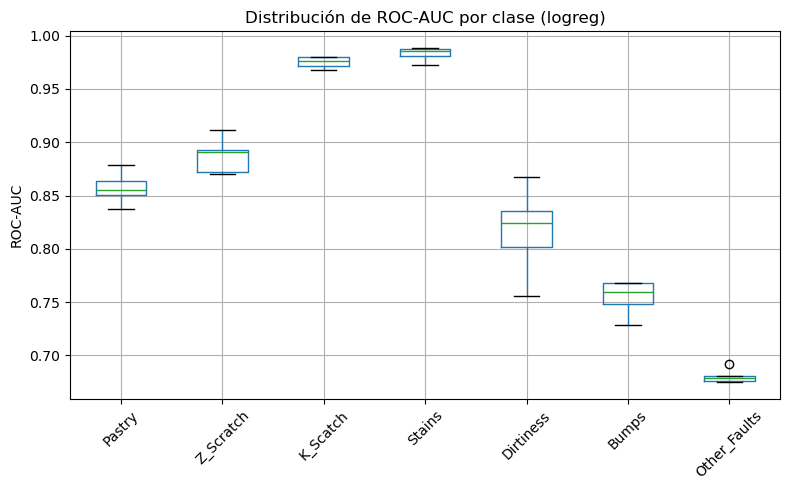

In [23]:
# Mostrar resultados completos (incluye train_time_sec para referencia)
display(df_cv)

# Media global de ROC-AUC
mean_auc = df_cv['mean_auc'].mean()
print(f"Media global ROC-AUC: {mean_auc:.4f}")

# Boxplot de AUC por clase (sin la columna de tiempo)
plt.figure(figsize=(8, 5))
classes = [c for c in df_cv.columns
           if c not in ['fold', 'mean_auc', 'train_time_sec']]   # ← excluimos tiempo
df_cv[classes].boxplot(rot=45)
plt.title(f"Distribución de ROC-AUC por clase ({MODEL_NAME})")
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.show()

In [50]:
# Mostrar resultados
display(cv_df)

# Media global
mean_auc = cv_df['mean_auc'].mean()
print(f"Media global ROC-AUC: {mean_auc:.4f}")

# Boxplot de AUC por clase
plt.figure(figsize=(8,5))
classes = [c for c in df_cv.columns if c not in ['fold','mean_auc']]
df_cv[classes].boxplot(rot=45)
plt.title(f"Distribución de ROC-AUC por clase oversampling ({MODEL_NAME})")
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.show()

NameError: name 'cv_df' is not defined

## 6. Entrenamiento final y guardado de modelos

In [52]:
# Preprocesador entrenado con todo el train_rem (85%)
X_rem = X.iloc[train_idx]
y_rem = y[train_idx]
X_rem_p = preprocessor.fit_transform(X_rem)

# Entrenar estimador final y guardar
if isinstance(estimator, list):
    for k, clf in enumerate(estimator):
        clf.fit(X_rem_p, y_rem[:,k])
        joblib.dump(clf, ROOT_DIR / 'models_artifacts' / '03_Notebook' / f'{MODEL_NAME}_label{k}_final.pkl')
else:
    estimator.fit(X_rem_p, y_rem)
    joblib.dump(estimator, ROOT_DIR / 'models_artifacts' / '03_Notebook' / f'{MODEL_NAME}_final.pkl')

# Guardar preprocesador final
joblib.dump(preprocessor, ROOT_DIR / 'models_artifacts' / '03_Notebook' / 'preprocessor' / 'preprocessor_final.pkl')

print("Modelos finales guardados en 'models/03_Notebook'")

[LightGBM] [Info] Number of positive: 1198, number of negative: 14514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5648
[LightGBM] [Info] Number of data points in the train set: 15712, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076247 -> initscore=-2.494460
[LightGBM] [Info] Start training from score -2.494460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [31]:
# -----------------------------------------------------------------------------
# Comparar métricas de validación cruzada entre modelos
# -----------------------------------------------------------------------------
TABLES_DIR = Path("../reports/tables")          
CSV_FILES  = TABLES_DIR.glob("*_cv_metrics.csv")

# ------------------------------------------------------------------ #
# 1) Cargar y combinar todos los CSV                                #
# ------------------------------------------------------------------ #
df_list = []
for file in CSV_FILES:
    model_name = file.stem.replace("_cv_metrics", "")   # p.ej. rf, lgbm, logreg, mlp
    tmp = pd.read_csv(file)
    tmp["model"] = model_name
    df_list.append(tmp)

cv_all = pd.concat(df_list, ignore_index=True)

# Detectar automáticamente las columnas de AUC (una por defecto)
aux_cols = {"fold", "train_time_sec", "model"}
defect_cols = [c for c in cv_all.columns if c not in aux_cols]

# ------------------------------------------------------------------ #
# 2) Resumen de AUC: media y σ por defecto y modelo                  #
# ------------------------------------------------------------------ #
auc_summary = (
    cv_all
    .groupby("model")[defect_cols]
    .agg(["mean", "std"])      # «mean» y «std» por defecto
    .transpose()               # más legible: defectos en filas
)

# ------------------------------------------------------------------ #
# 3) Resumen de tiempos de entrenamiento                             #
# ------------------------------------------------------------------ #
time_summary = (
    cv_all
    .groupby("model")["train_time_sec"]
    .agg(mean="mean", std="std")
    .sort_values(by="mean")
)

# ------------------------------------------------------------------ #
# 4) Mostrar                                                         #
# ------------------------------------------------------------------ #
print("=== AUC medio y desviación por defecto ===")
display(auc_summary)          
print("\n=== Tiempo de entrenamiento (segundos) ===")
display(time_summary)


=== AUC medio y desviación por defecto ===


model                  lgbm    logreg       mlp        rf
Pastry       mean  0.864334  0.856974  0.857132  0.856753
             std   0.013464  0.015513  0.011850  0.011728
Z_Scratch    mean  0.961181  0.887424  0.928144  0.946771
             std   0.003463  0.017003  0.020734  0.007171
K_Scatch     mean  0.983944  0.974988  0.977901  0.983388
             std   0.001674  0.005111  0.003836  0.002391
Stains       mean  0.990788  0.982721  0.983984  0.990301
             std   0.003068  0.006397  0.005618  0.002961
Dirtiness    mean  0.870357  0.817030  0.835311  0.871887
             std   0.030531  0.041535  0.043320  0.045449
Bumps        mean  0.814094  0.754421  0.786679  0.803210
             std   0.009948  0.016751  0.013543  0.011094
Other_Faults mean  0.706092  0.680725  0.696682  0.704036
             std   0.012317  0.006810  0.008049  0.011553
mean_auc     mean  0.884399  0.850612  0.866547  0.879478
             std   0.005169  0.006090  0.006066  0.008478


=== Tiempo de entrenamiento (segundos) ===


,mean,std
model,,
lgbm,3.908980,0.242391
mlp,5.987797,0.341063
logreg,8.579006,0.061911
rf,21.590154,0.214121


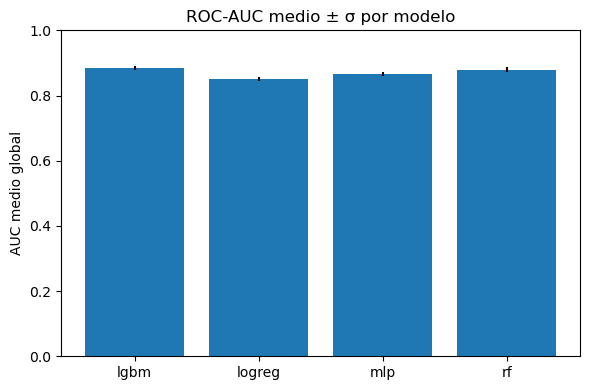

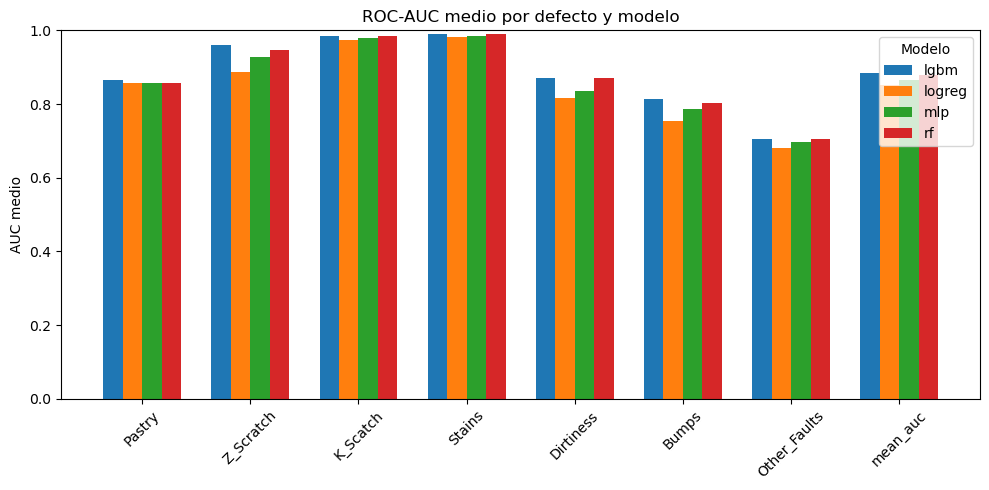

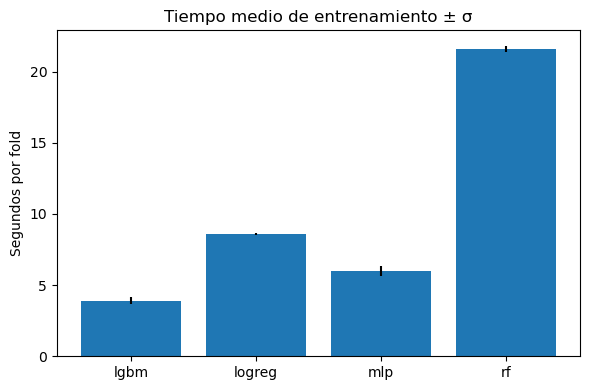

In [35]:
# ---------------------------------------------------------------
# Visualizaciones comparativas entre modelos
# (requiere que cv_all y defect_cols estén ya en memoria)
# ---------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# 1) Resúmenes numéricos -----------------------------------------
overall_auc = (
    cv_all
    .groupby("model")["mean_auc"]
    .agg(["mean", "std"])
    .reset_index()
)

auc_by_def = cv_all.groupby("model")[defect_cols].mean()   # (model × defecto)

time_summary = (
    cv_all
    .groupby("model")["train_time_sec"]
    .agg(["mean", "std"])
    .reset_index()
)

# 2) Plot: AUC medio global --------------------------------------
plt.figure(figsize=(6, 4))
plt.bar(overall_auc["model"], overall_auc["mean"],
        yerr=overall_auc["std"])
plt.ylim(0.0, 1.0)
plt.ylabel("AUC medio global")
plt.title("ROC-AUC medio ± σ por modelo")
plt.tight_layout()
plt.show()

# 3) Plot: AUC por defecto y modelo ------------------------------
plt.figure(figsize=(10, 5))
x = np.arange(len(defect_cols))
width = 0.18
for idx, (model, row) in enumerate(auc_by_def.iterrows()):
    plt.bar(x + idx * width, row.values, width, label=model)

plt.xticks(x + width * (len(auc_by_def) - 1) / 2,
           defect_cols, rotation=45)
plt.ylim(0.0, 1.0)
plt.ylabel("AUC medio")
plt.title("ROC-AUC medio por defecto y modelo")
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()

# 4) Plot: Tiempo de entrenamiento -------------------------------
plt.figure(figsize=(6, 4))
plt.bar(time_summary["model"], time_summary["mean"],
        yerr=time_summary["std"])
plt.ylabel("Segundos por fold")
plt.title("Tiempo medio de entrenamiento ± σ")
plt.tight_layout()
plt.show()
